In [1]:
import pandas as pd
from hydroDL.data import usgs, gageII, gridMET, ntn, GLASS, transform, dbBasin
import numpy as np
import matplotlib.pyplot as plt
from hydroDL.post import axplot, figplot, mapplot
from hydroDL import kPath, utils
import os
import sklearn.tree
import matplotlib.gridspec as gridspec


# investigate correlation between simlicity and basin attributes.
# remove carbon - less obs, high corr

codeLst = usgs.varC

DF = dbBasin.DataFrameBasin('G200')
# count
matB = (~np.isnan(DF.c)*~np.isnan(DF.q[:, :, 0:1])).astype(int).astype(float)
count = np.nansum(matB, axis=0)

matRm = count < 200

# load linear/seasonal
dirP = r'C:\Users\geofk\work\waterQuality\modelStat\LR-All\{}\param'
labLst = ['Q', 'S', 'QS']
dictS = dict()
for lab in labLst:
    dirS = dirP.format(lab)
    matLR = np.full([len(DF.siteNoLst), len(codeLst)], np.nan)
    for k, code in enumerate(codeLst):
        filePar = os.path.join(dirS, code)
        dfCorr = pd.read_csv(
            filePar, dtype={'siteNo': str}).set_index('siteNo')
        matLR[:, k] = dfCorr['rsq'].values
    matLR[matRm] = np.nan
    dictS[lab] = matLR

matQ = dictS['Q']
matS = dictS['S']
matQS = dictS['QS']

# global variables

td = pd.to_datetime(DF.t).dayofyear
lat, lon = DF.getGeo()


loading package hydroDL
Find negative Q, filled zero


c:\Users\geofk\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


3038 extremes removed
loading data G200 11.27s


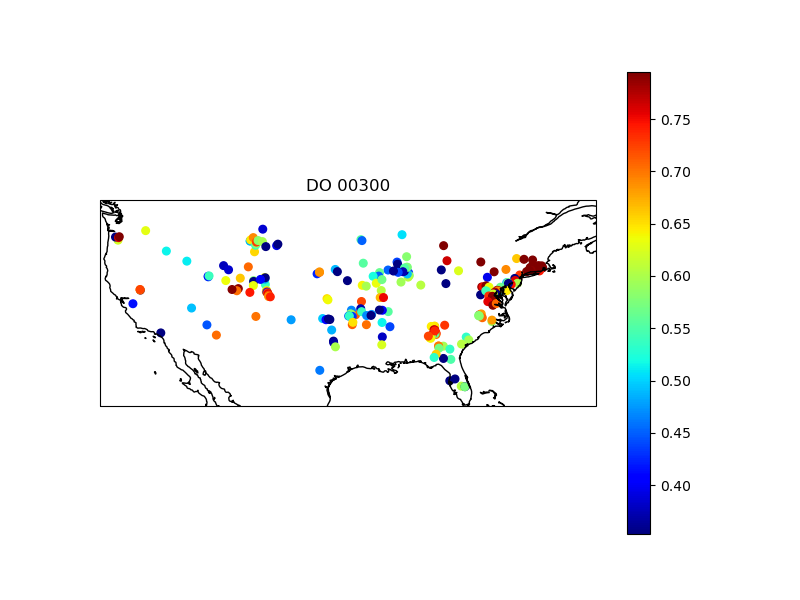

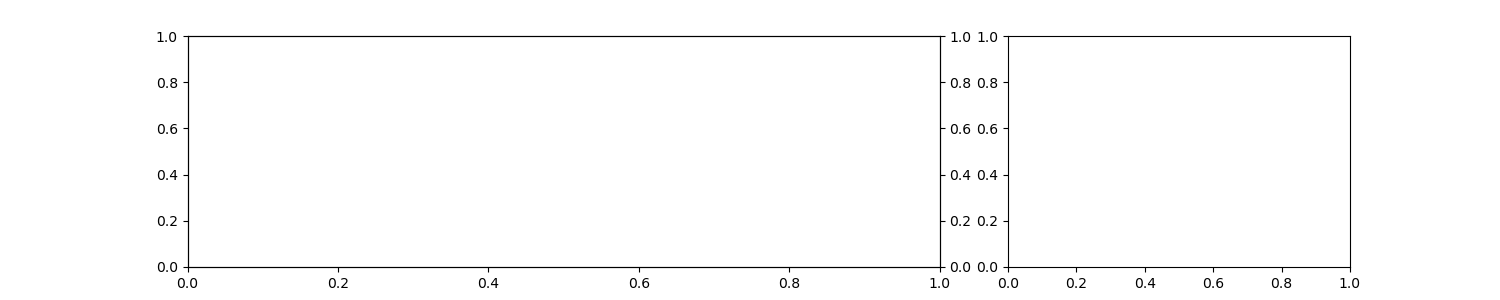

(<Figure size 800x600 with 2 Axes>, <Figure size 1500x300 with 3 Axes>)

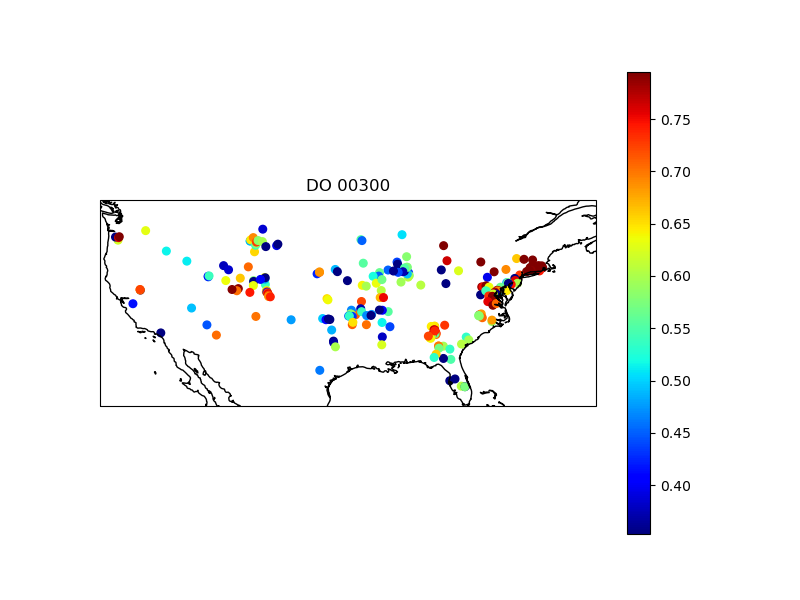

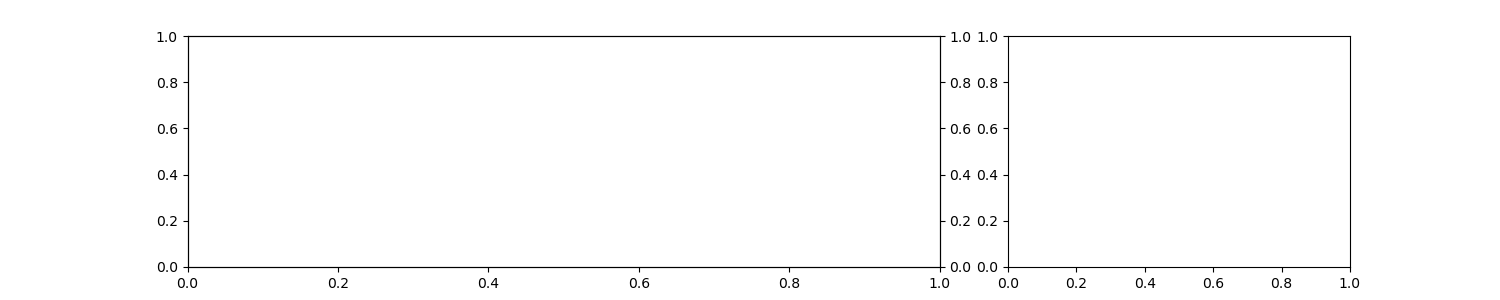

In [7]:
%matplotlib widget
# seasonal
code = '00300'
indC = codeLst.index(code)
indS = np.where(~matRm[:, indC])[0]

def funcM():
    figM = plt.figure(figsize=(8, 6))
    gsM = gridspec.GridSpec(1, 1)
    axM = mapplot.mapPoint(
        figM, gsM[0, 0], lat[indS], lon[indS], matS[indS, indC])
    axM.set_title('{} {}'.format(usgs.codePdf.loc[code]['shortName'], code))
    figP = plt.figure(figsize=(15, 3))
    gsP = gridspec.GridSpec(1, 3)
    ax = figP.add_subplot(gsP[0, 0:2])
    axS = figP.add_subplot(gsP[0, 2])
    axT = ax.twinx()
    axPLst = [ax, axT, axS]
    axP = np.array(axPLst)
    return figM, axM, figP, axP, lon[indS], lat[indS]


def funcP(iP, axP):
    print(iP)
    iS = indS[iP]
    [ax, axT, axS] = axP
    x = (DF.f[:, iS, DF.varF.index('tmmn')] +
         DF.f[:, iS, DF.varF.index('tmmx')])/2-273.15
    q = DF.q[:, iS, 1]
    c = DF.c[:, iS, indC]
    axplot.plotTS(axT, DF.t, -x, cLst='b', lineW=[0.1])
    axplot.plotTS(ax, DF.t, c, cLst='r')
    codeStr = usgs.codePdf.loc[DF.varC[indC]]['shortName']
    ax.set_title('{} {} linearity = {:.2f}, seasonality = {:.2f}'.format(
        DF.siteNoLst[iS], codeStr, matQ[iS, indC], matS[iS, indC]))
    sc = axS.scatter(np.log(q), c, c=td, cmap='hsv', vmin=0, vmax=365)


figplot.clickMap(funcM, funcP)